In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
%matplotlib inline
pd.set_option('display.max_columns', 100)

In [36]:
all_pair = pd.read_csv("../data/allPair.csv",low_memory=False)
universities = pd.read_csv("../data/university.csv")
state = 'CA'

def state_df(df, state):
    return df[df['state'] == state]

state_pair = state_df(all_pair, state)
state_univ = state_df(universities, state)

In [37]:
def home_count_to_univ(df):
    '''
    find the number of homes to the nearest university, grouped by university
    '''
    state_grouped = df.groupby('UniversityName')
    home_count = state_grouped.size()
    home_count.sort_values(inplace=True,ascending=False)
    home_count_df = pd.DataFrame({"UniversityName":home_count.index, "homeCount":home_count.values})
    return state_grouped, home_count_df

In [38]:
def distcorr_univ(pair, max_dist):
    '''
    find the saleprice-distance correlation for each university, and append it as a column in home_count_to_university
    '''
    pair = pair[pair['distance']<max_dist]
    state_grouped_by_univ, home_count_to_university = home_count_to_univ(pair)
    univNames = home_count_to_university['UniversityName'].tolist()
    home_count_to_university['distCorr'] = np.nan

    for i in range(len(univNames)):
        univ = home_count_to_university.loc[home_count_to_university.index[i], 'UniversityName']
        df = state_grouped_by_univ.get_group(univ)
        corr = df.corr()
        home_count_to_university.loc[home_count_to_university.index[i], 'distCorr'] = corr['saleprice']['distance']

    return home_count_to_university


In [53]:
def corr_all(pair, univ, dist=100):
    '''
    find the correlation between features and distcorr for each university
    '''
    distcorr_df = distcorr_univ(pair,dist)
    df = pd.merge(univ, distcorr_df, on='UniversityName', how='inner')
    features = ["acceptanceRate","ranking","enroll","acadStaff","students","underGrad","postGrad"]

    # convert object features to int, then plot it vs distCorr
    for f in features:
        dff = df[[f, 'distCorr']]
        dff.dropna(axis=1, how='any')
        dff[f] = pd.to_numeric(dff[f], downcast='integer', errors='coerce')
        dff = dff.sort_values(by=f)
        plt.figure()
        plt.scatter(dff[f], dff['distCorr'])
        plt.xlabel(f)
        plt.ylabel("distCorr")
        plt.show()
    

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


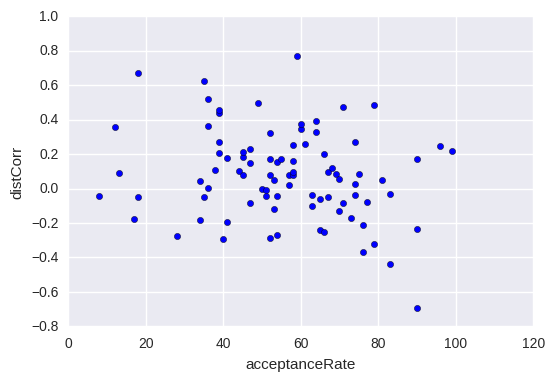

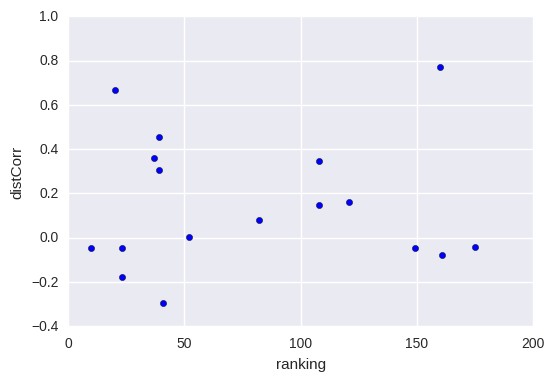

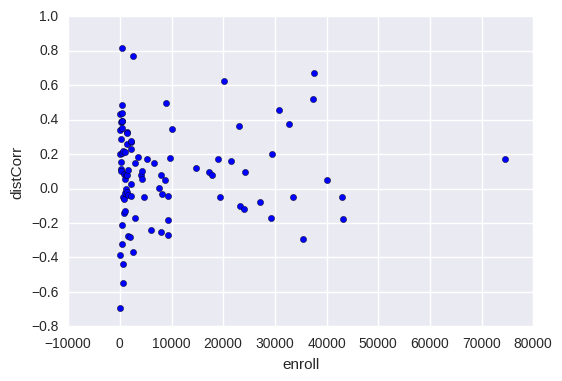

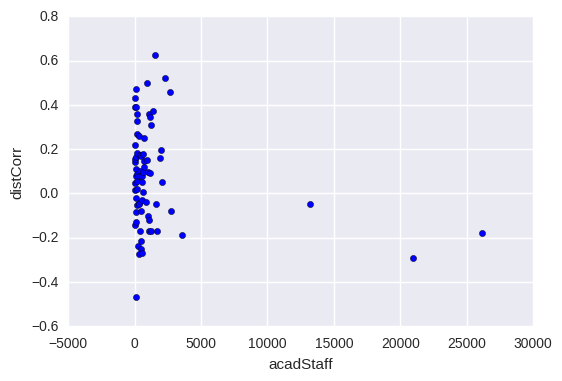

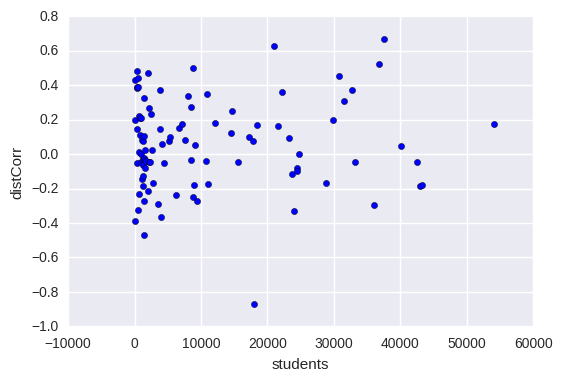

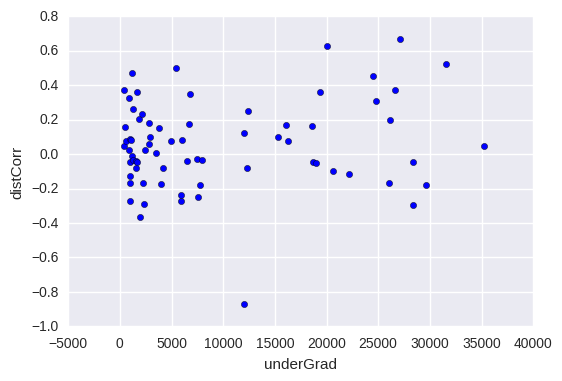

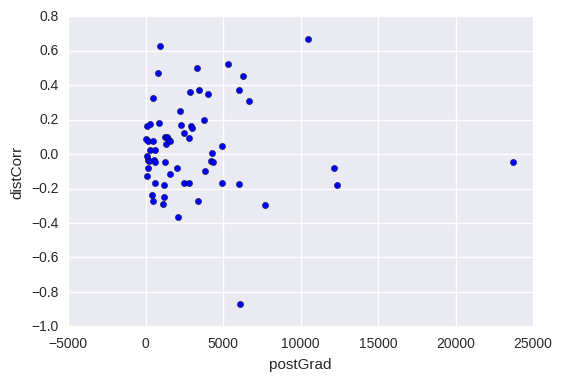

In [54]:
corr_all(state_pair, state_univ, 10)
    

In [128]:
def feature_group(pair, features, dist):
    for feature in features:
        pair_df = pair[[feature, 'UniversityName','saleprice', 'distance']]
        pair_df = pair_df[pair_df['distance'] < dist]
        pair_df.dropna(axis=1, how='any')
        pair_df['saleprice'] = pd.to_numeric(pair_df['saleprice'], downcast='integer', errors='coerce')
        pair_df = pair_df[pair_df['saleprice'] > 0]
        
        # find the 3 universities with most homes paired to it
        pair_grouped = pair_df.groupby('UniversityName')
        home_count = pair_grouped.size()
        home_count.sort_values(inplace=True,ascending=False)
        home_count_top3 = home_count[:3]
        univ_names = [name for name in home_count_top3.index]
        
        # plot price vs distance for each university features
        for univ_name in univ_names:
            univ = pair_grouped.get_group(univ_name)
            one_univ_grouped = univ.groupby(feature)
            for fea in set(univ[feature]):
                univ_one_feat = one_univ_grouped.get_group(fea)
                plt.plot(univ_one_feat['distance'], univ_one_feat['saleprice'], linestyle='none', marker='o', label=fea)

            plt.xlabel('distance')
            plt.ylabel('sale price')
            plt.title(univ_name + ' by ' + feature)
            plt.legend(loc='best')
            plt.show()

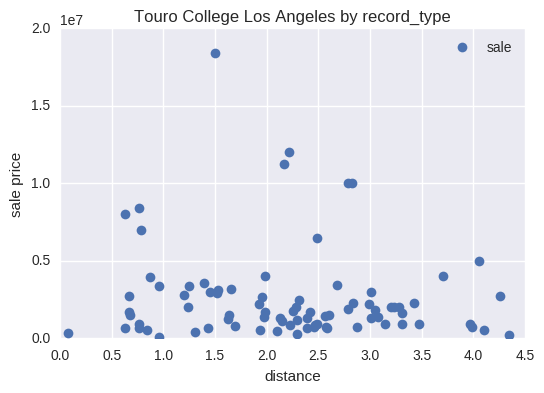

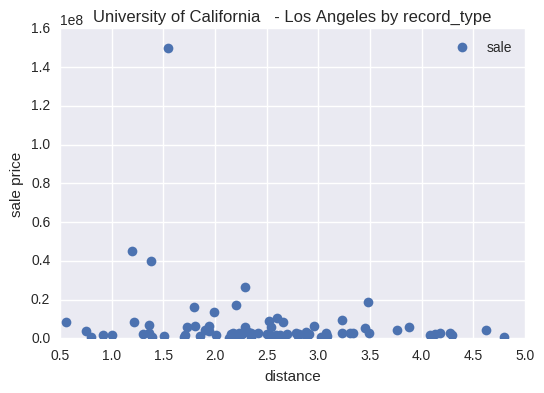

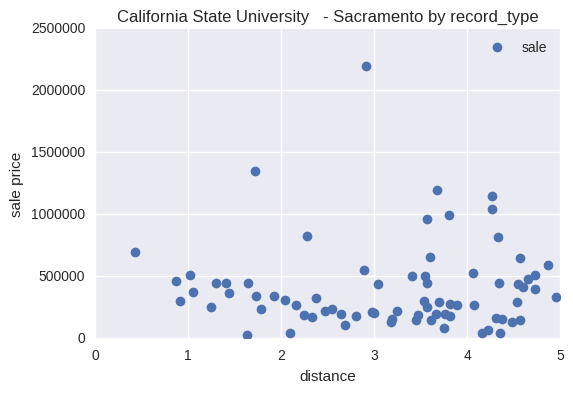

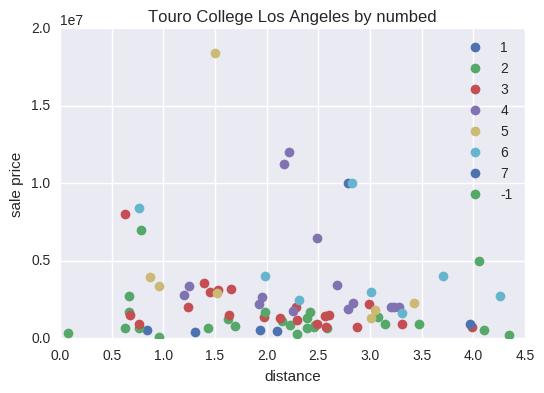

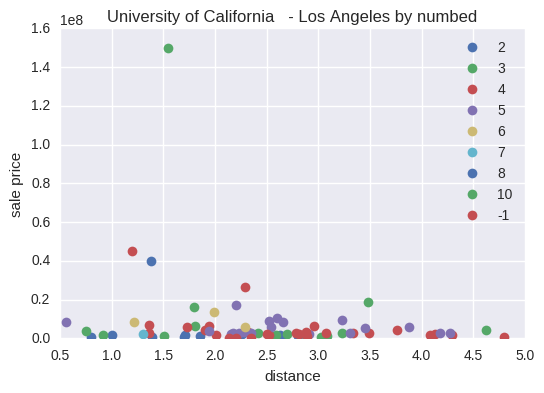

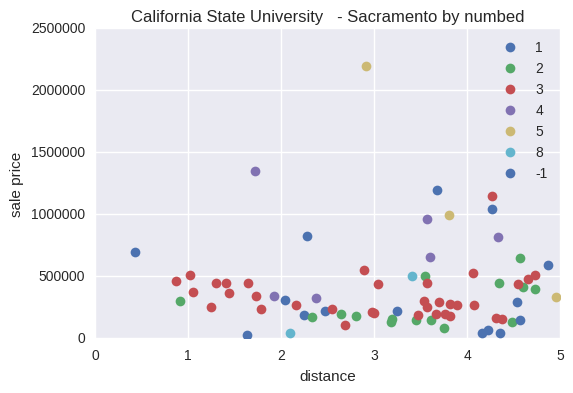

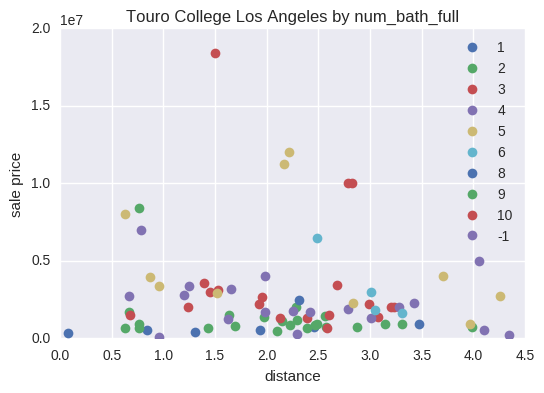

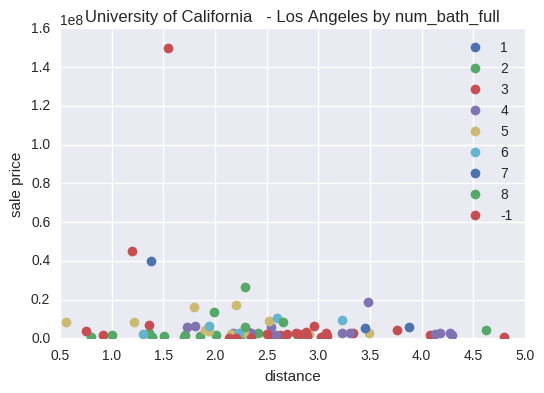

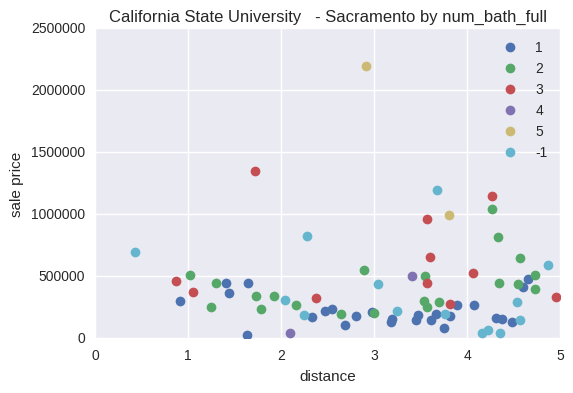

In [129]:
features = ['record_type','numbed','num_bath_full']
# features = ['numbed','num_bath_full']
feature_group(state_pair, features, 5)